In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# ------------------ Configuration ------------------

# Load CSVs
predictions_baseline = pd.read_csv("Results/model_predictions.csv (5-window).csv")
predictions_chronos = pd.read_csv("Results/chronos(5-day).csv")
predictions_timesfm = pd.read_csv("Results/timesfm(5-day).csv")
predictions_uni2ts = pd.read_csv("Results/uni2ts(5-day)predictions.csv")

# Convert 'DlyCalDt' to datetime
for df in [predictions_baseline, predictions_chronos, predictions_timesfm, predictions_uni2ts]:
    df['DlyCalDt'] = pd.to_datetime(df['DlyCalDt'])

# Sort by date
for df in [predictions_baseline, predictions_chronos, predictions_timesfm, predictions_uni2ts]:
    df.sort_values(by=["DlyCalDt", "PERMNO"], inplace=True, ignore_index=True)


top_n = 10  # Top N stocks to go long
bottom_n = 10 # Bottom N stocks to go short

# Combine all predictions into a single DataFrame
exclude_columns = ['DlyCalDt', 'PERMNO', 'ExcessReturn']

baseline_cols = predictions_baseline.columns.tolist()
chronos_cols = [cols for cols in predictions_chronos.columns.tolist() if cols not in exclude_columns]
timesfm_cols = [cols for cols in predictions_timesfm.columns.tolist() if cols not in exclude_columns]
uni2ts_cols = [cols for cols in predictions_uni2ts.columns.tolist() if cols not in exclude_columns] 

# Concatenate along axis=1 (columns), aligned by index
combined_df = pd.concat([
    predictions_baseline[baseline_cols],
    predictions_chronos[chronos_cols],
    predictions_timesfm[timesfm_cols],
    predictions_uni2ts[uni2ts_cols]
], axis=1)

combined_df.rename(columns={
    'DlyCalDt': 'Date',
    'ExcessReturn': 'Actual'
}, inplace=True)

In [16]:
combined_df

PERMNO       Date    Actual     Ridge       OLS  ElasticNet     Lasso  \
0        10138 2016-01-04 -0.018191  0.001656  0.001656    0.000936  0.000671   
1        17778 2016-01-04 -0.007616  0.001042  0.001042    0.000936  0.000710   
2        28388 2016-01-04 -0.015413  0.001246  0.001246    0.000956  0.000716   
3        34746 2016-01-04 -0.027370  0.001118  0.001118    0.000842  0.000659   
4        35044 2016-01-04 -0.016674  0.001194  0.001194    0.000826  0.000631   
...        ...        ...       ...       ...       ...         ...       ...   
112395   86455 2024-12-31  0.000924  0.000539  0.000539    0.000789  0.000689   
112396   86755 2024-12-31 -0.008607  0.000525  0.000525    0.000778  0.000736   
112397   86868 2024-12-31 -0.001733 -0.000002 -0.000002    0.000432  0.000625   
112398   87267 2024-12-31 -0.002370  0.001420  0.001420    0.000838  0.000771   
112399   92655 2024-12-31 -0.003932  0.000651  0.000651    0.000536  0.000621   

             GLM        RF       NN1  ...  y_chr_bolt_small  y_chr_bolt_base  \
0       0.001465  0.000419  0.000662  ...         -0.009591        -0.007507   
1       0.001242  0.000417  0.000258  ...         -0.009653        -0.008324   
2       0.001136  0.000421  0.000818  ...         -0.016556        -0.013321   
3       0.001255  0.000406 -0.001097  ...         -0.007421        -0.006852   
4       0.001268  0.000417 -0.000303  ...         -0.004597        -0.005088   
...          ...       ...       ...  ...               ...              ...   
112395  0.000884  0.000415 -0.000332  ...         -0.013456        -0.010389   
112396  0.000912  0.000415  0.000592  ...         -0.017278        -0.014044   
112397  0.000157  0.000414 -0.000107  ...         -0.007352        -0.004432   
112398  0.000939  0.000418  0.000791  ...         -0.021085        -0.018935   
112399  0.000399  0.000413 -0.000152  ...         -0.003508        -0.003262   

        y_chr_t5_tiny  y_chr_t5_mini  y_chr_t5_small    y_tfm1    y_tfm2  \
0           -0.007548      -0.003380       -0.003928 -0.004481 -0.009021   
1           -0.008974      -0.002516       -0.000681 -0.003673 -0.006993   
2           -0.004105      -0.006542       -0.006307 -0.003597 -0.009432   
3           -0.006471      -0.005552       -0.003093 -0.003450 -0.007972   
4           -0.005068      -0.005366       -0.002771 -0.002181 -0.007945   
...               ...            ...             ...       ...       ...   
112395      -0.006726      -0.009496       -0.004525 -0.003708 -0.009292   
112396      -0.011223      -0.013500       -0.007489 -0.006929 -0.009531   
112397      -0.002583      -0.004695       -0.004053  0.000315 -0.005863   
112398      -0.011643      -0.016488       -0.013070 -0.014655 -0.009866   
112399      -0.002869      -0.003077       -0.002571  0.001466 -0.003638   

        y_moirai_s  y_moirai_moe_s  y_moirai_moe_b  
0        -0.003469       -0.002999       -0.002102  
1         0.004277        0.000037        0.001335  
2        -0.002959        0.002250       -0.003005  
3         0.003057        0.005902        0.003944  
4         0.016010       -0.001052        0.003133  
...            ...             ...             ...  
112395    0.003837        0.001826       -0.003503  
112396   -0.003096       -0.001682        0.023733  
112397    0.023588        0.007256        0.008485  
112398    0.003780        0.000215        0.000637  
112399    0.014247        0.010863        0.005207  

[112400 rows x 27 columns]

In [ ]:
# Calculate returns for the baseline portfolio

def sharpe_ratio(df, column_name):
    returns = df[column_name]
    cumulative = (1 + returns).cumprod()
    mean_return = returns.mean()
    vol = returns.std()
    sharpe = mean_return / vol * np.sqrt(252)  # Daily Returns, annualized Sharpe Ratio
    return cumulative, sharpe

#print(f"Sharpe Ratio for actual returns: {sharpe:.4f}")

Sharpe Ratio for actual returns: 0.4552


### Sharpe Ratio for actual returns: 0.4552


In [117]:

def build_long_short_portfolio(df, column_name, n=10):
    
    long_short_returns = []
    
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(column_name, ascending=False)
        no_of_stocks = round((n/100)*len(sorted_group))
        top = sorted_group.head(no_of_stocks)
        bottom = sorted_group.tail(no_of_stocks)
        avg_return = top['Actual'].mean() - bottom['Actual'].mean()
        long_short_returns.append((date, avg_return))
    
    return pd.DataFrame(long_short_returns, columns=["Date", "Returns"])

In [119]:
model_cols = [
    'Ridge', 'OLS', 'ElasticNet', 'Lasso', 'GLM', 'RF',
    'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'GBRT',
    'y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
    'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small',
    'y_tfm1', 'y_tfm2',
    'y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b'
]

portfolio_returns = {}

for model in model_cols:
    ls_df = build_long_short_portfolio(combined_df, model)
    ls_df.set_index('Date', inplace=True)
    portfolio_returns[model] = ls_df['Returns']

# Combine all into one DataFrame
portfolio_df = pd.DataFrame(portfolio_returns)
portfolio_df

Ridge       OLS  ElasticNet     Lasso       GLM        RF  \
Date                                                                       
2016-01-04 -0.000854 -0.000854   -0.015783 -0.011359 -0.006818  0.009404   
2016-01-05 -0.001575 -0.001575   -0.011879 -0.004539 -0.010181 -0.005757   
2016-01-06 -0.005021 -0.005021   -0.012583 -0.012583 -0.007012 -0.007983   
2016-01-07 -0.018233 -0.018233   -0.019752 -0.019752 -0.015286  0.010984   
2016-01-08 -0.003349 -0.003349   -0.002811  0.000025 -0.005441  0.002139   
...              ...       ...         ...       ...       ...       ...   
2024-12-24  0.007254  0.007254    0.009793  0.010626  0.008176 -0.001309   
2024-12-26  0.001937  0.001937    0.000718  0.000449  0.000030 -0.002113   
2024-12-27 -0.001980 -0.001980    0.001082  0.000951 -0.002045  0.000221   
2024-12-30  0.004151  0.004151   -0.002246 -0.005438  0.002000 -0.002651   
2024-12-31  0.002325  0.002325   -0.002305 -0.005706  0.001090  0.003967   

                 NN1       NN2       NN3       NN4  ...  y_chr_bolt_small  \
Date                                                ...                     
2016-01-04  0.006738 -0.010662  0.001010  0.014912  ...          0.005205   
2016-01-05  0.003557 -0.005169 -0.000270 -0.015466  ...          0.003094   
2016-01-06  0.013492 -0.008722  0.001828 -0.008966  ...          0.011364   
2016-01-07 -0.001465 -0.014957 -0.006977 -0.004247  ...          0.017642   
2016-01-08  0.011517  0.009074  0.011571  0.008613  ...         -0.002842   
...              ...       ...       ...       ...  ...               ...   
2024-12-24 -0.004145  0.002643 -0.000687  0.001372  ...         -0.009616   
2024-12-26 -0.002232 -0.001114  0.005004  0.001001  ...          0.000729   
2024-12-27  0.002305  0.003412 -0.001839  0.002821  ...         -0.000383   
2024-12-30  0.000993  0.000564  0.003489  0.003972  ...          0.005735   
2024-12-31  0.003341  0.003226  0.003384  0.004581  ...          0.006796   

            y_chr_bolt_base  y_chr_t5_tiny  y_chr_t5_mini  y_chr_t5_small  \
Date                                                                        
2016-01-04         0.008732       0.011694       0.007367        0.005779   
2016-01-05         0.004539       0.003300      -0.003329        0.005000   
2016-01-06         0.011364       0.007019       0.007021        0.011473   
2016-01-07         0.019752       0.012568       0.014096        0.017854   
2016-01-08        -0.002607       0.005607      -0.003887        0.005922   
...                     ...            ...            ...             ...   
2024-12-24        -0.009665      -0.005490      -0.011683       -0.006191   
2024-12-26        -0.000170       0.000661       0.000202       -0.001064   
2024-12-27        -0.003380      -0.003065      -0.001603       -0.001234   
2024-12-30         0.003814       0.001312      -0.000983       -0.002235   
2024-12-31         0.006216       0.003331       0.004936        0.002906   

              y_tfm1    y_tfm2  y_moirai_s  y_moirai_moe_s  y_moirai_moe_b  
Date                                                                        
2016-01-04  0.008191  0.006025    0.001604       -0.000149       -0.004393  
2016-01-05  0.007509  0.010696   -0.005382        0.000236       -0.003270  
2016-01-06  0.012608  0.014847   -0.000620       -0.001368        0.002635  
2016-01-07  0.012554  0.016275   -0.010857       -0.004298       -0.010089  
2016-01-08  0.001886 -0.002812   -0.004395       -0.001168       -0.009449  
...              ...       ...         ...             ...             ...  
2024-12-24 -0.009853 -0.008178   -0.004300       -0.007131       -0.007587  
2024-12-26 -0.002004 -0.005322   -0.000804       -0.005242       -0.005701  
2024-12-27 -0.000309 -0.001536    0.000176       -0.000770       -0.000679  
2024-12-30  0.002332  0.003272    0.001603       -0.001273        0.000805  
2024-12-31  0.003517  0.001157   -0.003762       -0.003471       -0.008375  

[2248 rows x 24 colu

In [ ]:
# Compute cumulative returns for each model (assuming daily returns)
cumulative_returns = portfolio_df.cumsum()

# Download S&P 500 daily close prices over the same date range
sp500 = yf.download("^GSPC", start=portfolio_df.index.min(), end=portfolio_df.index.max())

# Calculate daily returns of S&P 500
sp500['Return'] = sp500['Close'].pct_change()

# Calculate cumulative returns
sp500['Cumulative Return'] = sp500['Return'].cumsum()

# Calculate compounded returns
sp500['Compounded Returns'] = (1+sp500['Return']).cumprod()


C:\Users\amaan\AppData\Local\Temp\ipykernel_24464\1674897509.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=portfolio_df.index.min(), end=portfolio_df.index.max())
[*********************100%***********************]  1 of 1 completed


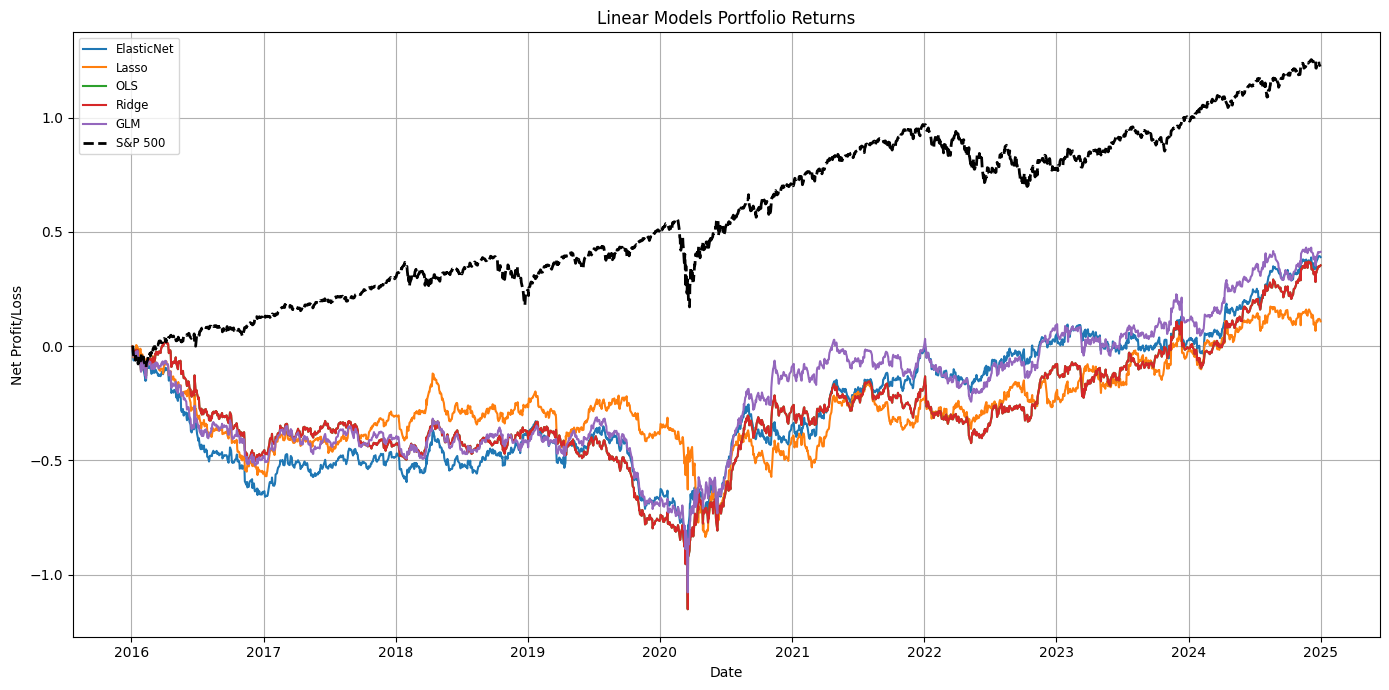

In [140]:
# Plotting returns of linear models vs S&P 500

plt.figure(figsize=(14,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Linear Models Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

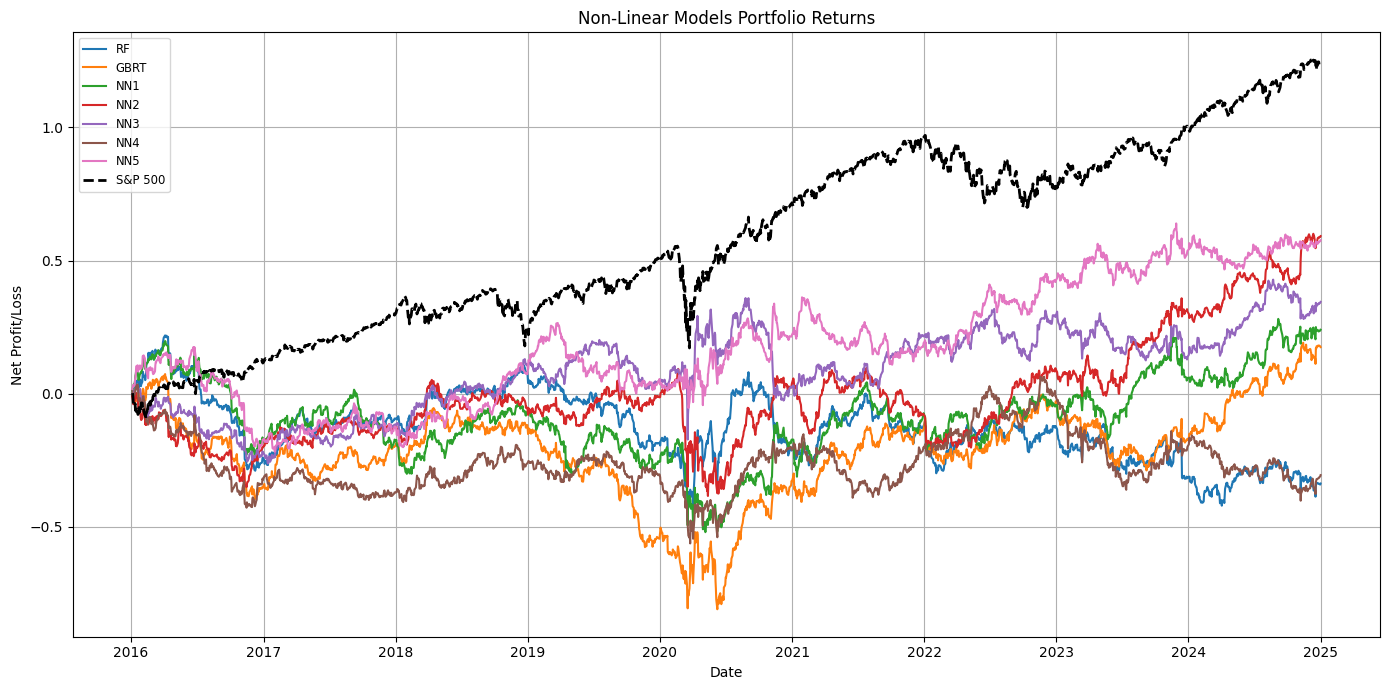

In [141]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(14,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Non-Linear Models Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

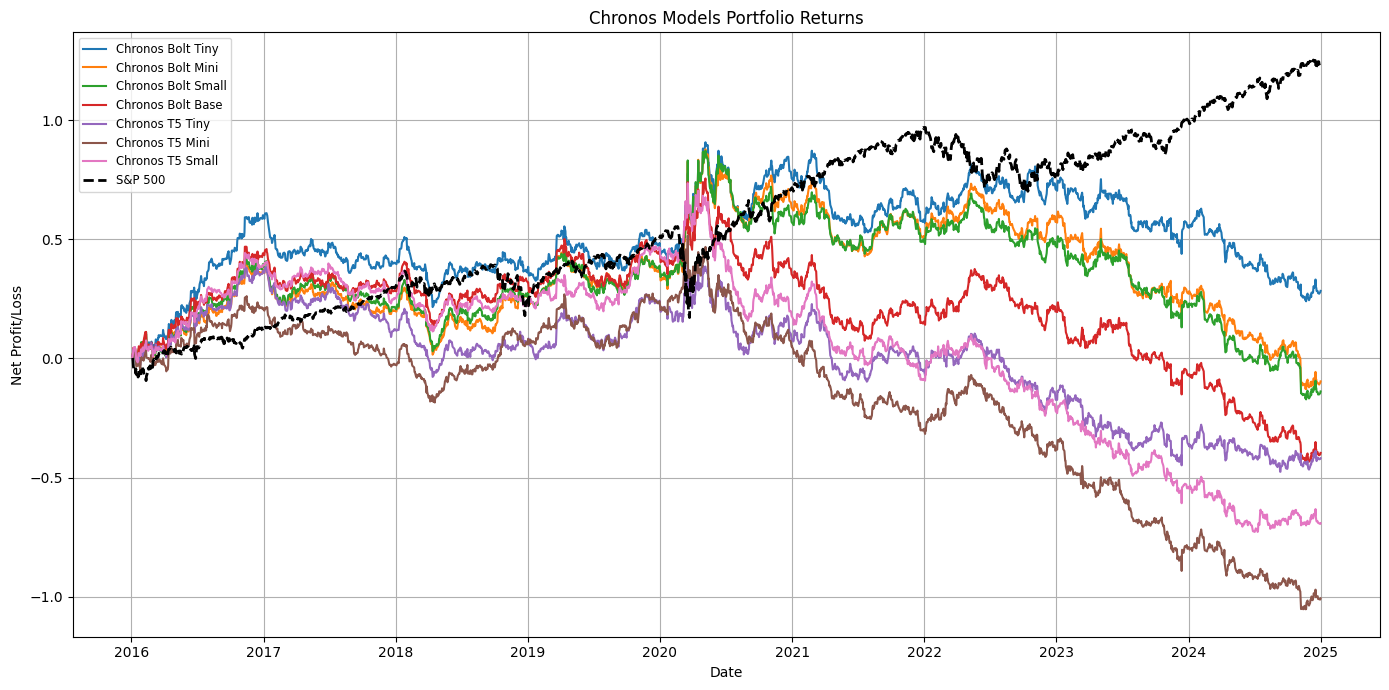

In [137]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(14,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Chronos Models Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


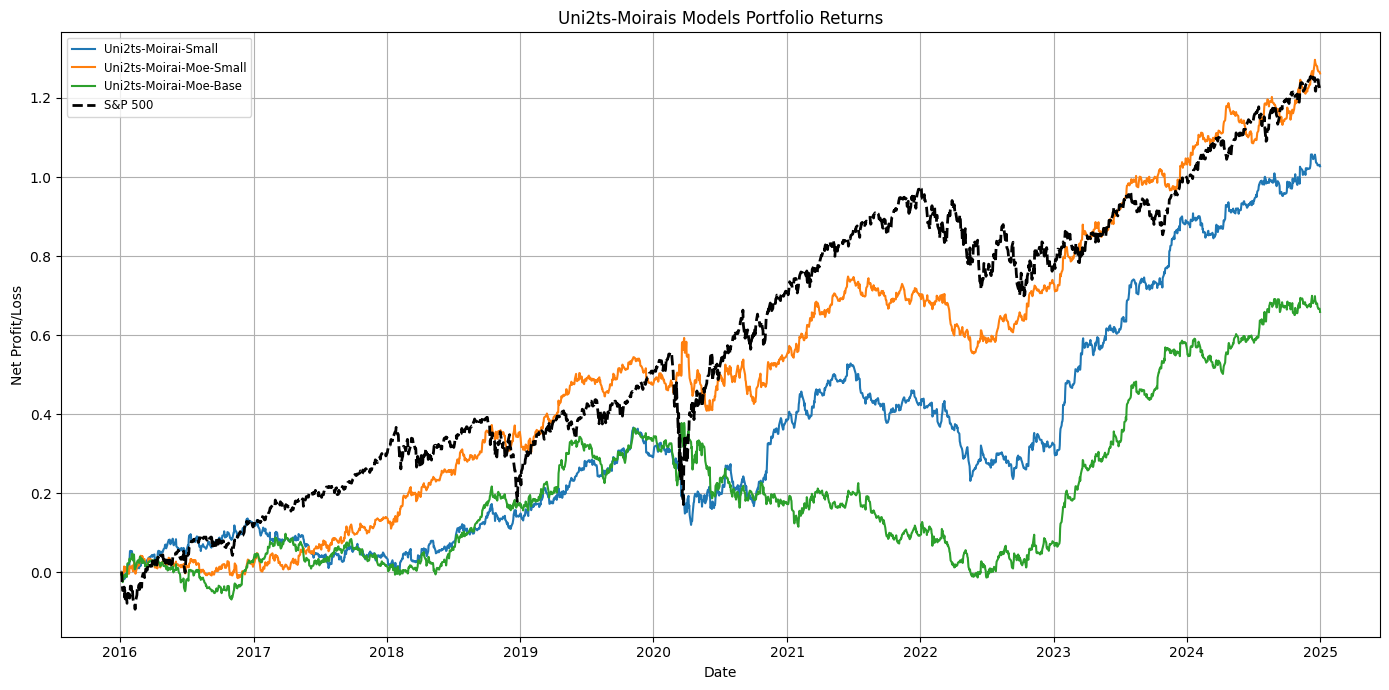

In [142]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(14,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Uni2ts-Moirais Models Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


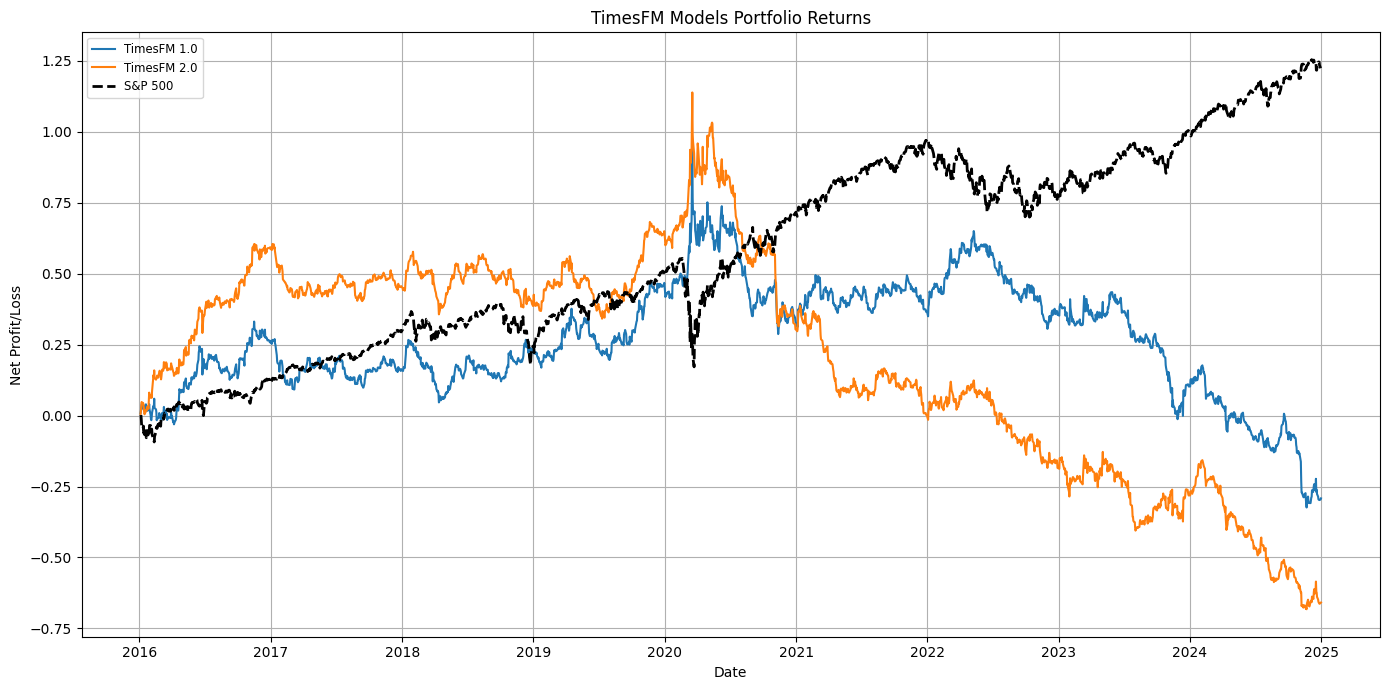

In [135]:
# Plotting returns of TimesFM models vs S&P 500

plt.figure(figsize=(14,7))

timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("TimesFM Models Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

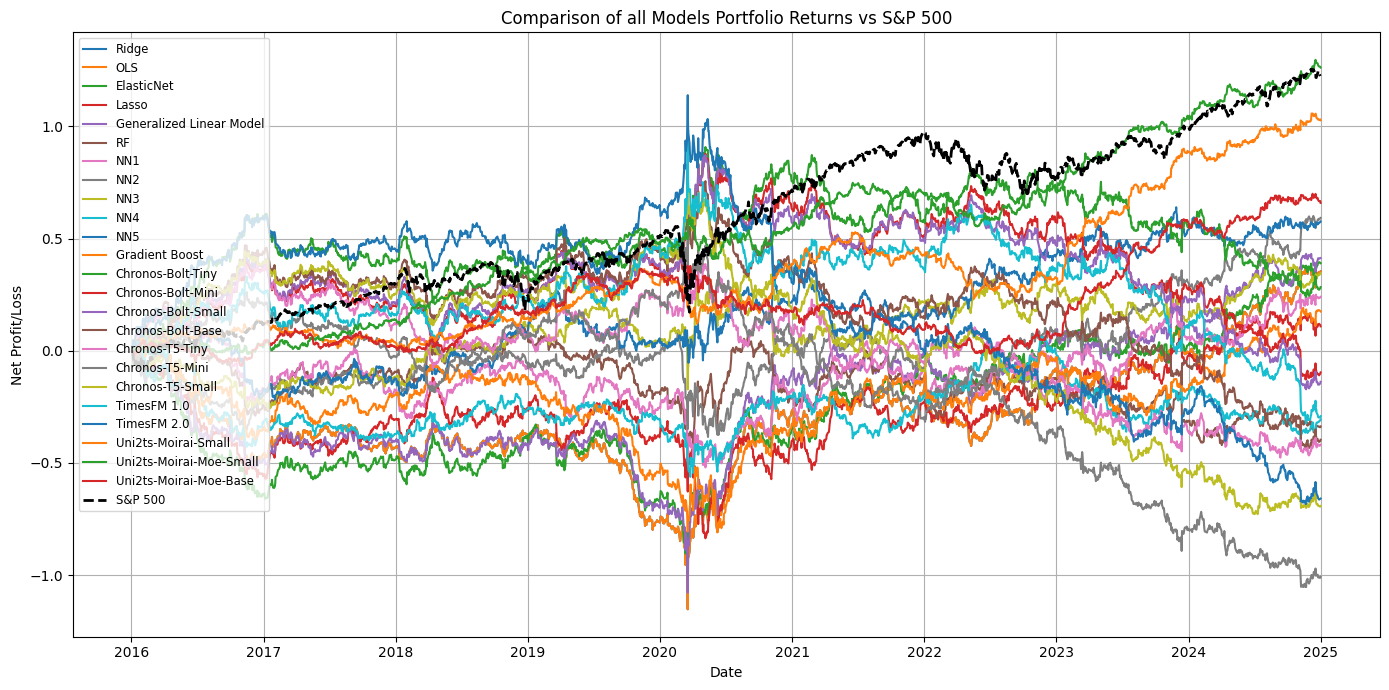

In [143]:
# Plotting returns of all models vs S&P 500

plt.figure(figsize=(14,7))

models_dict = {"OLS": "OLS",
               "Lasso": "Lasso",
               "Ridge": "Ridge",
               "ElasticNet": "ElasticNet",
               "RF": "RF",
               "GLM": "Generalized Linear Model",
               "GBRT": "Gradient Boost",
               "NN1": "NN1",
               "NN2": "NN2",
               "NN3": "NN3",
               "NN4": "NN4",
               "NN5": "NN5",
               "y_chr_bolt_tiny": "Chronos-Bolt-Tiny",
               "y_chr_bolt_mini": "Chronos-Bolt-Mini",
               "y_chr_bolt_small": "Chronos-Bolt-Small",
               "y_chr_bolt_base": "Chronos-Bolt-Base",
               "y_chr_t5_tiny": "Chronos-T5-Tiny",
               "y_chr_t5_mini": "Chronos-T5-Mini",
               "y_chr_t5_small": "Chronos-T5-Small",
               "y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0",
               "y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
               }

# Portfolios
for col in model_cols:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=models_dict[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Comparison of all Models Portfolio Returns vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def sharpe_ratio(df, column_name):
    returns = df[column_name]
    cumulative = (1 + returns).cumprod()
    mean_return = returns.mean()
    vol = returns.std()
    sharpe = mean_return / vol * np.sqrt(252)  # Daily Returns, annualized Sharpe Ratio
    return cumulative, sharpe

# Calculate Sharpe ratios for all models
sharpe_ratios = {}
for model in model_cols:
    cumulative, sharpe = sharpe_ratio(portfolio_df, model)
    sharpe_ratios[model] = sharpe

sharpe_ratios_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])

sharpe_ratios_df

Sharpe Ratio
Ridge                 0.165319
OLS                   0.165319
ElasticNet            0.184742
Lasso                 0.050646
GLM                   0.188530
RF                   -0.178449
NN1                   0.125138
NN2                   0.321336
NN3                   0.190938
NN4                  -0.179869
NN5                   0.327161
GBRT                  0.091423
y_chr_bolt_tiny       0.133238
y_chr_bolt_mini      -0.044442
y_chr_bolt_small     -0.064340
y_chr_bolt_base      -0.187584
y_chr_t5_tiny        -0.218864
y_chr_t5_mini        -0.517229
y_chr_t5_small       -0.368614
y_tfm1               -0.133346
y_tfm2               -0.304526
y_moirai_s            0.936613
y_moirai_moe_s        1.194424
y_moirai_moe_b        0.598961

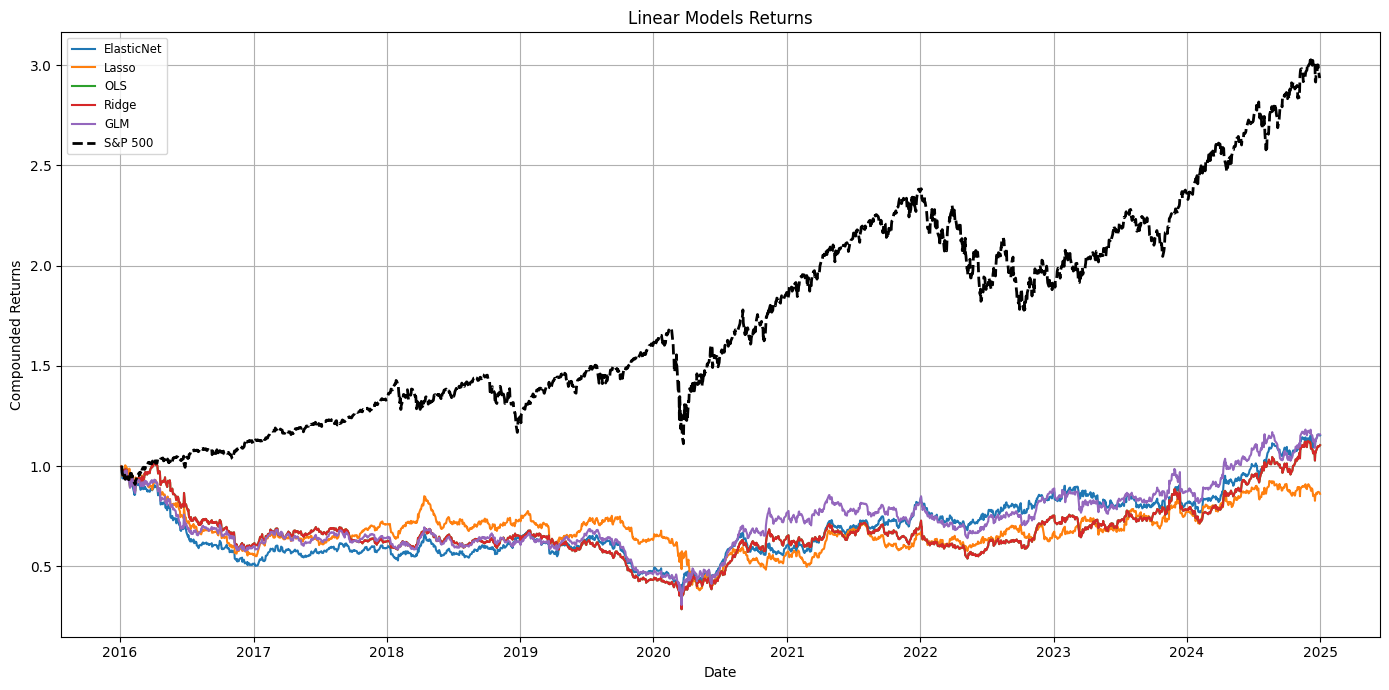

In [144]:
# Plotting compounded returns of linear models vs S&P 500

plt.figure(figsize=(14,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Linear Models Returns")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

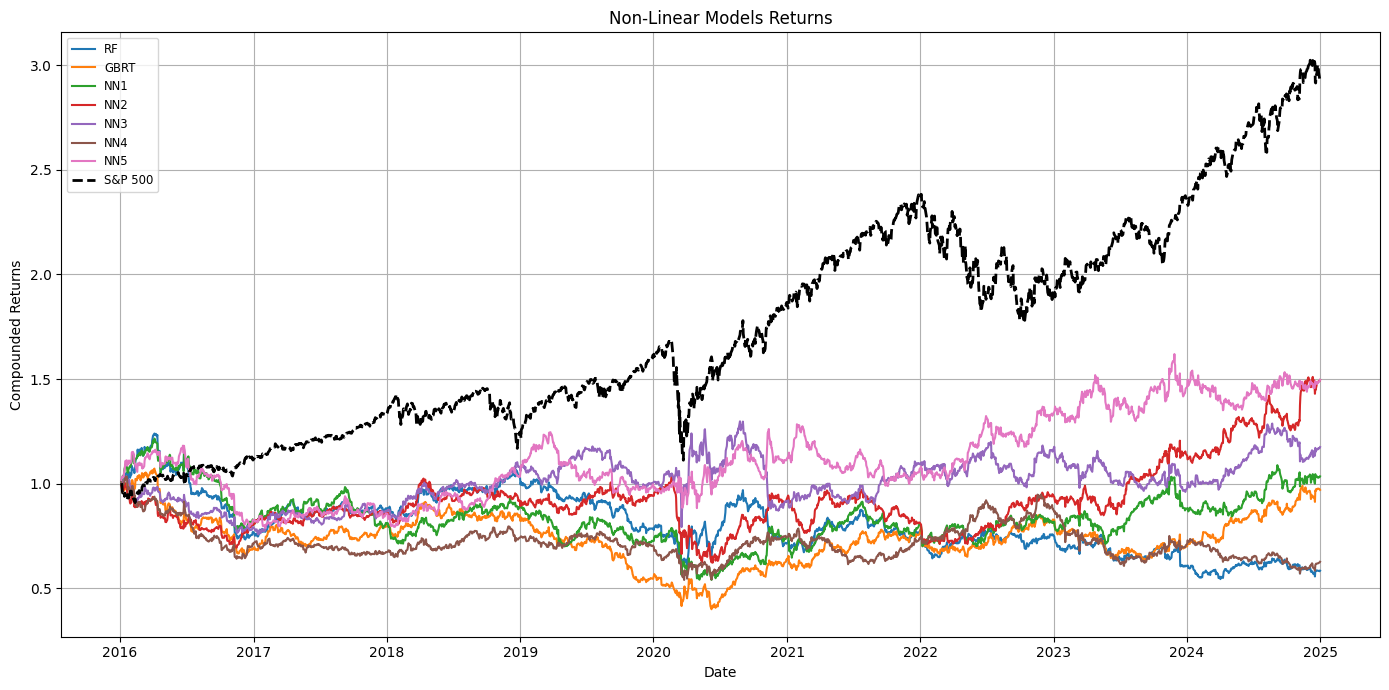

In [146]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(14,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Non-Linear Models Returns")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

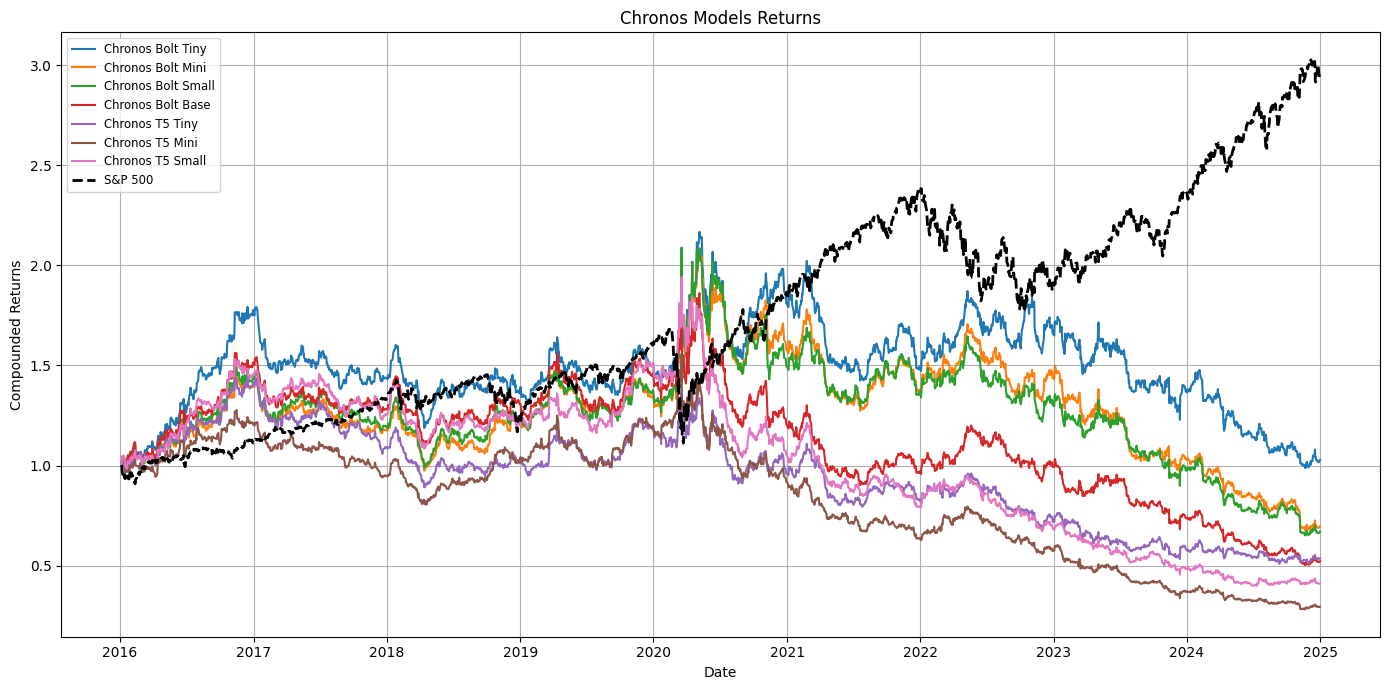

In [147]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(14,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Chronos Models Returns")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


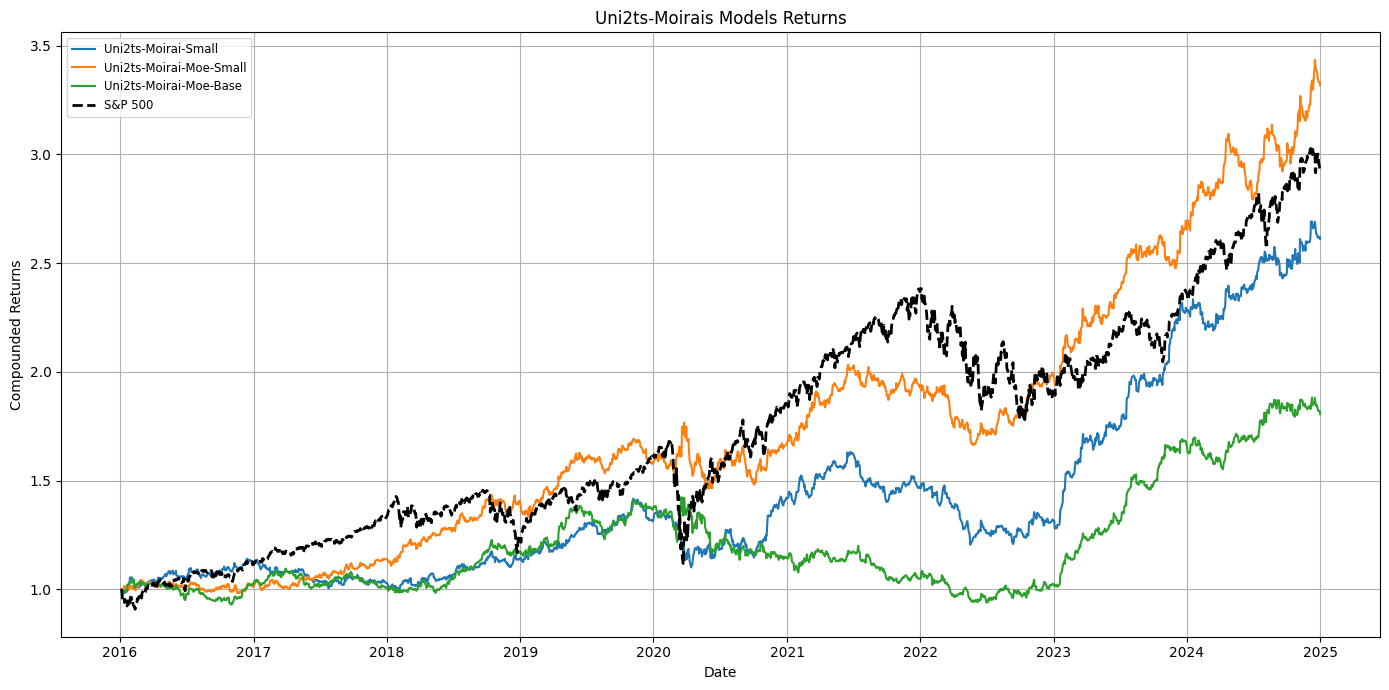

In [148]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(14,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Uni2ts-Moirais Models Returns")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


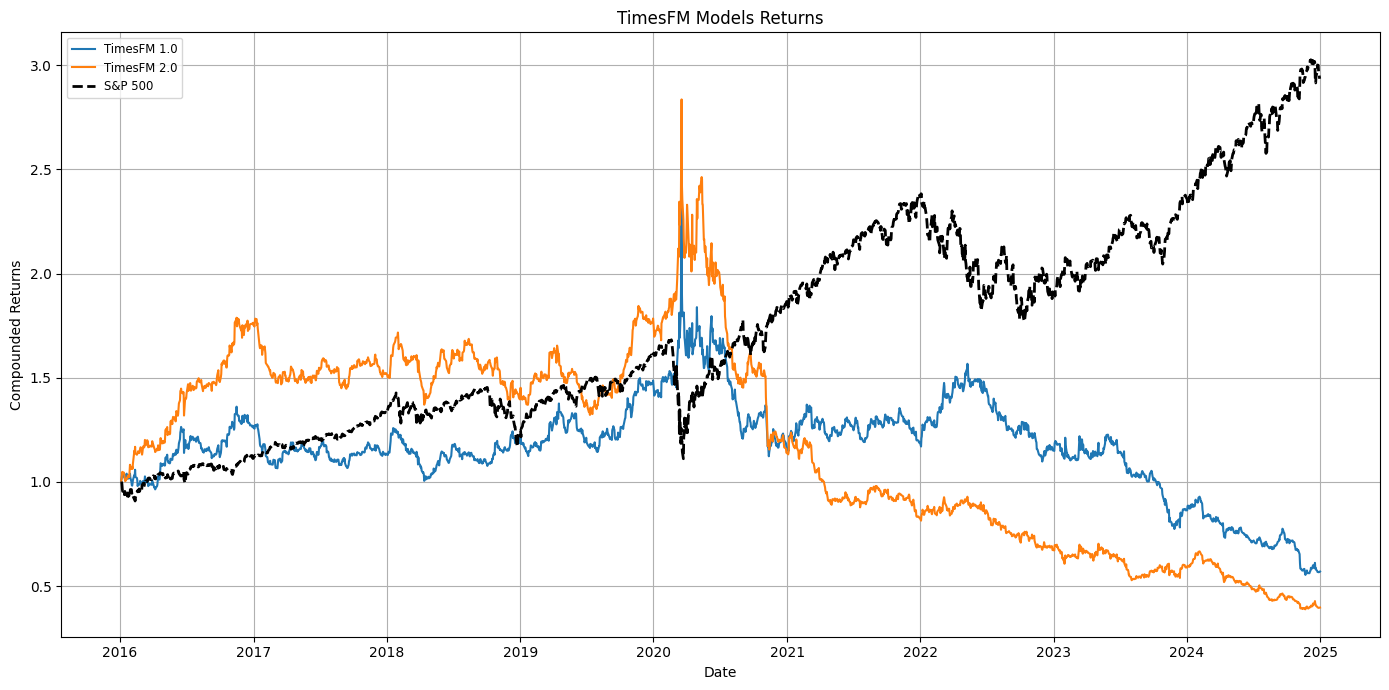

In [149]:
# Plotting returns of TimesFM models vs S&P 500

plt.figure(figsize=(14,7))

timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("TimesFM Models Returns")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

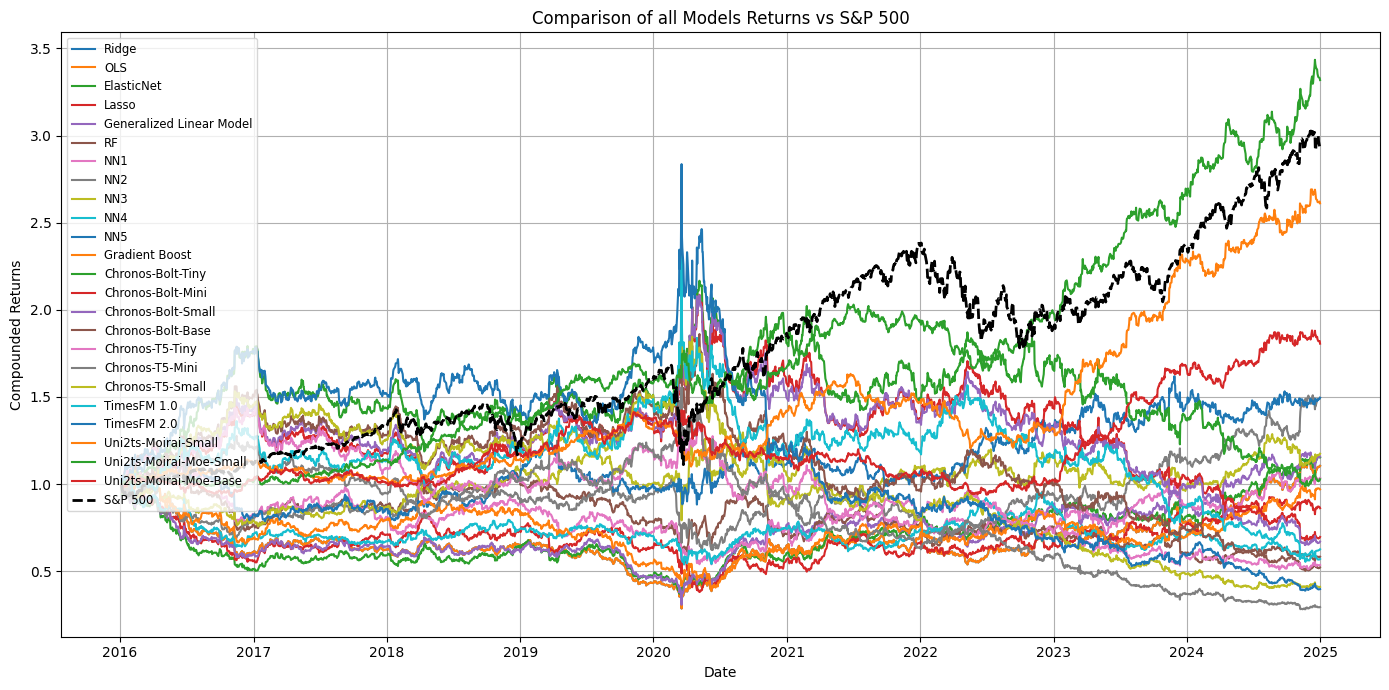

In [152]:
# Plotting returns of all models vs S&P 500

plt.figure(figsize=(14,7))

models_dict = {"OLS": "OLS",
               "Lasso": "Lasso",
               "Ridge": "Ridge",
               "ElasticNet": "ElasticNet",
               "RF": "RF",
               "GLM": "Generalized Linear Model",
               "GBRT": "Gradient Boost",
               "NN1": "NN1",
               "NN2": "NN2",
               "NN3": "NN3",
               "NN4": "NN4",
               "NN5": "NN5",
               "y_chr_bolt_tiny": "Chronos-Bolt-Tiny",
               "y_chr_bolt_mini": "Chronos-Bolt-Mini",
               "y_chr_bolt_small": "Chronos-Bolt-Small",
               "y_chr_bolt_base": "Chronos-Bolt-Base",
               "y_chr_t5_tiny": "Chronos-T5-Tiny",
               "y_chr_t5_mini": "Chronos-T5-Mini",
               "y_chr_t5_small": "Chronos-T5-Small",
               "y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0",
               "y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
               }

# Portfolios
for col in model_cols:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=models_dict[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Comparison of all Models Returns vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [168]:
# Function to calculate performance metrics

def performance_metrics(df, column_name):
    returns = df[column_name]

    avg_daily_return = returns.mean()
    ann_return = avg_daily_return * 252
    daily_vol = returns.std()
    ann_vol = daily_vol * np.sqrt(252)
    sharpe = avg_daily_return / daily_vol * np.sqrt(252)

    return {
        'Avg Daily Return': avg_daily_return,
        'Annualized Return': ann_return,
        'Daily Volatility': daily_vol,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe    
        }


In [ ]:
metrics_dict = {}

for model in model_cols:
    metrics = performance_metrics(portfolio_df, model)
    metrics_dict[model] = {k: v for k, v in metrics.items()}

# Create summary DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

metrics_df

Avg Daily Return  Annualized Return  Daily Volatility  \
Ridge                     0.000157           0.039673          0.015117   
OLS                       0.000157           0.039673          0.015117   
ElasticNet                0.000174           0.043728          0.014911   
Lasso                     0.000048           0.012184          0.015155   
GLM                       0.000184           0.046285          0.015465   
RF                       -0.000150          -0.037816          0.013349   
NN1                       0.000107           0.026918          0.013550   
NN2                       0.000263           0.066326          0.013002   
NN3                       0.000153           0.038643          0.012749   
NN4                      -0.000136          -0.034280          0.012006   
NN5                       0.000256           0.064589          0.012436   
GBRT                      0.000078           0.019616          0.013516   
y_chr_bolt_tiny           0.000126           0.031789          0.015030   
y_chr_bolt_mini          -0.000043          -0.010799          0.015306   
y_chr_bolt_small         -0.000062          -0.015524          0.015199   
y_chr_bolt_base          -0.000176          -0.044446          0.014926   
y_chr_t5_tiny            -0.000186          -0.046946          0.013512   
y_chr_t5_mini            -0.000448          -0.112900          0.013750   
y_chr_t5_small           -0.000308          -0.077568          0.013256   
y_tfm1                   -0.000130          -0.032719          0.015457   
y_tfm2                   -0.000293          -0.073860          0.015279   
y_moirai_s                0.000457           0.115151          0.007745   
y_moirai_moe_s            0.000561           0.141478          0.007462   
y_moirai_moe_b            0.000293           0.073850          0.007767   

                  Annualized Volatility  Sharpe Ratio  
Ridge                          0.239980      0.165319  
OLS                            0.239980      0.165319  
ElasticNet                     0.236697      0.184742  
Lasso                          0.240572      0.050646  
GLM                            0.245504      0.188530  
RF                             0.211913     -0.178449  
NN1                            0.215105      0.125138  
NN2                            0.206407      0.321336  
NN3                            0.202388      0.190938  
NN4                            0.190585     -0.179869  
NN5                            0.197421      0.327161  
GBRT                           0.214564      0.091423  
y_chr_bolt_tiny                0.238587      0.133238  
y_chr_bolt_mini                0.242982     -0.044442  
y_chr_bolt_small               0.241277     -0.064340  
y_chr_bolt_base                0.236937     -0.187584  
y_chr_t5_tiny                  0.214499     -0.218864  
y_chr_t5_mini                  0.218279     -0.517229  
y_chr_t5_small                 0.210432     -0.368614  
y_tfm1                         0.245369     -0.133346  
y_tfm2                         0.242542     -0.304526  
y_moirai_s                     0.122944      0.936613  
y_moirai_moe_s                 0.118449      1.194424  
y_moirai_moe_b                 0.123297      0.598961

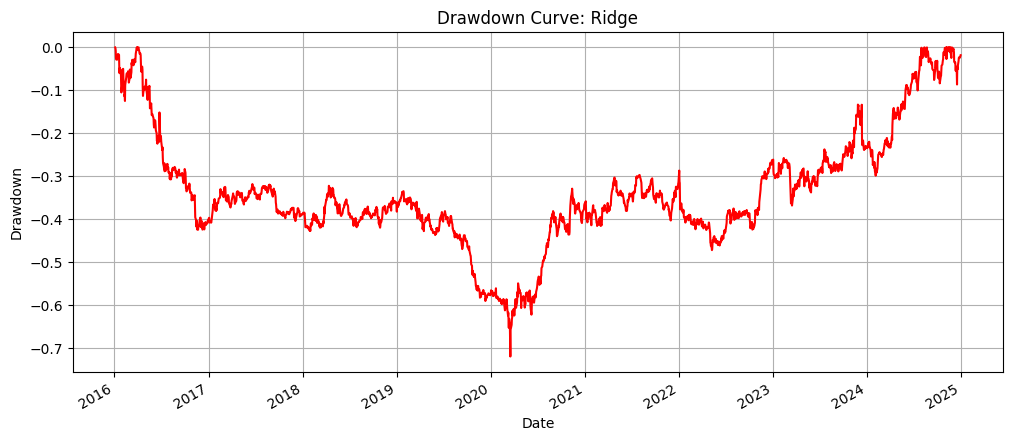

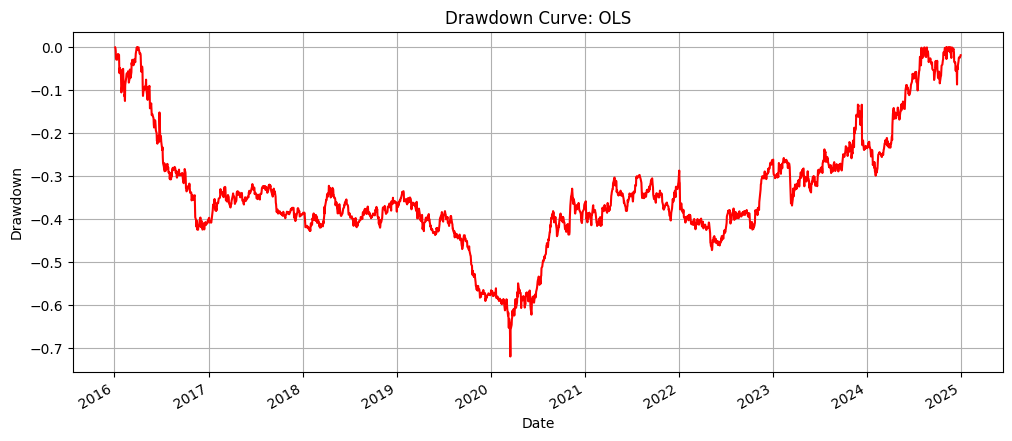

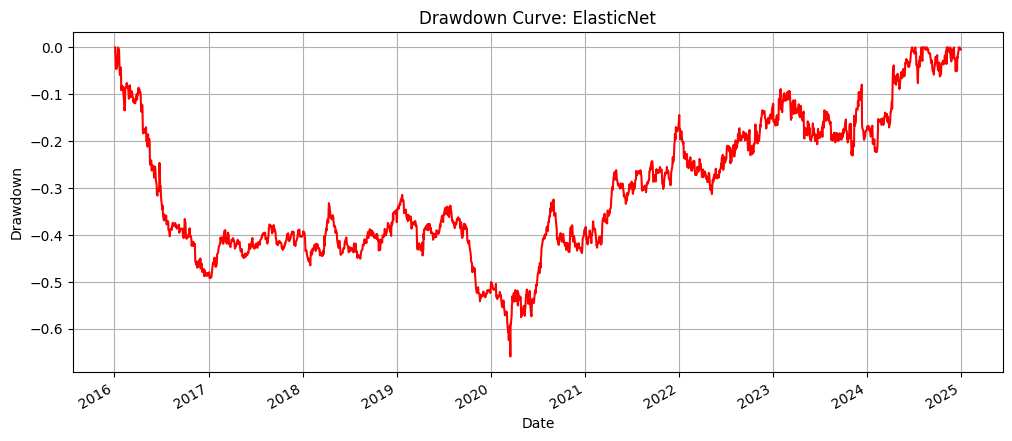

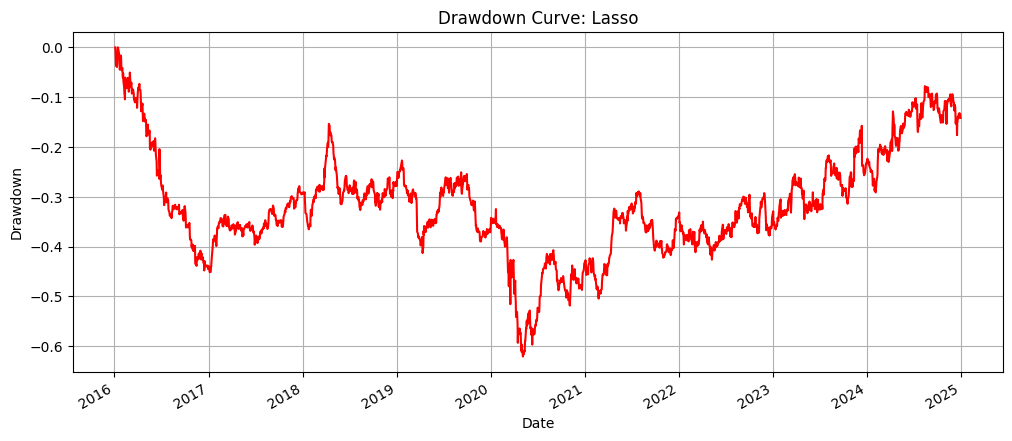

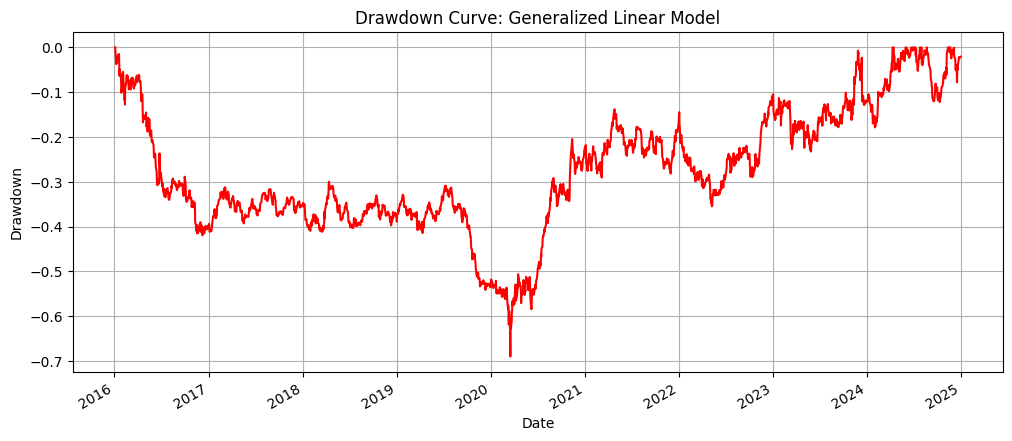

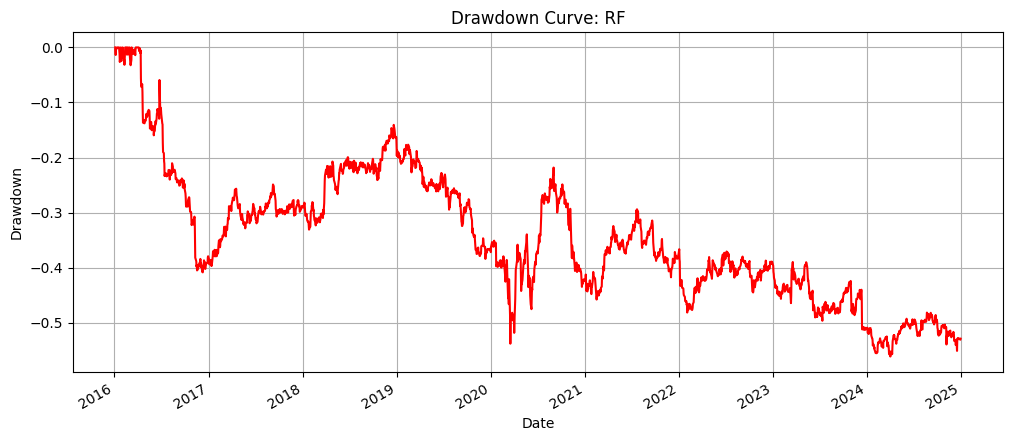

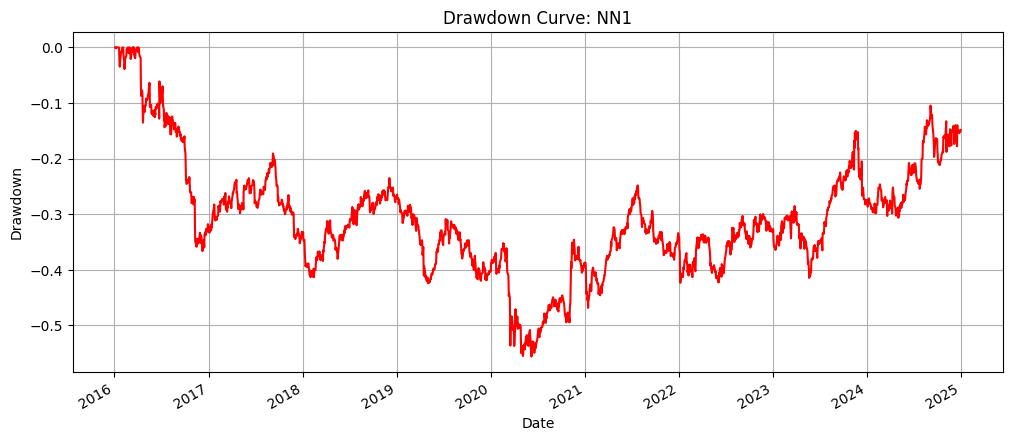

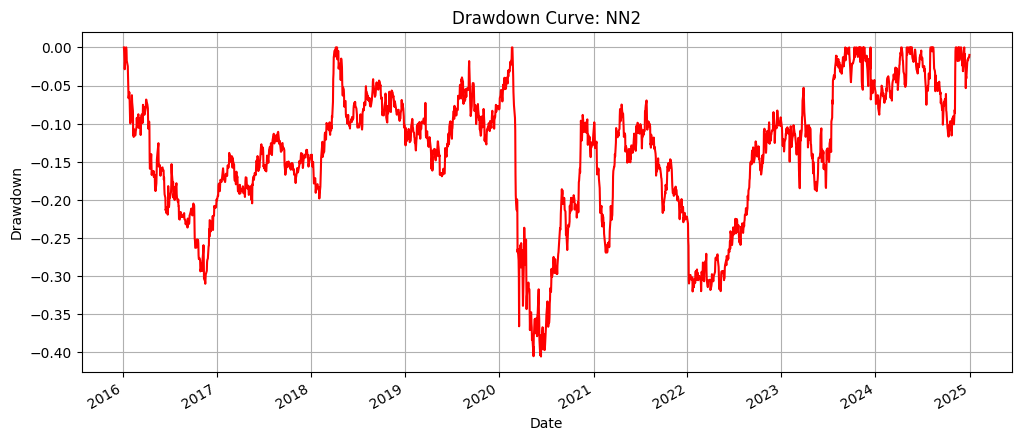

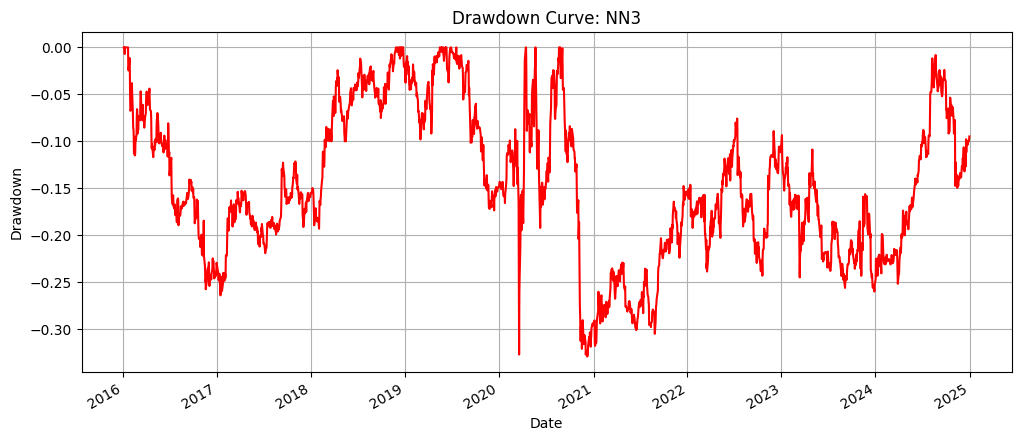

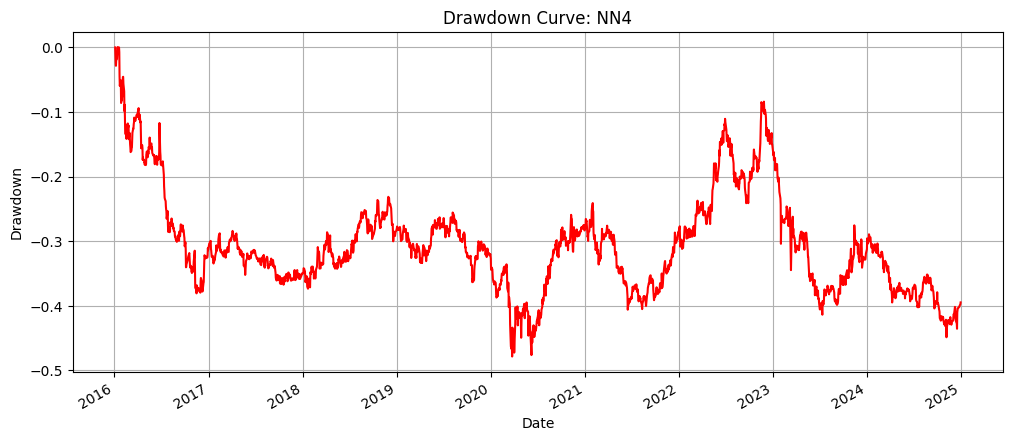

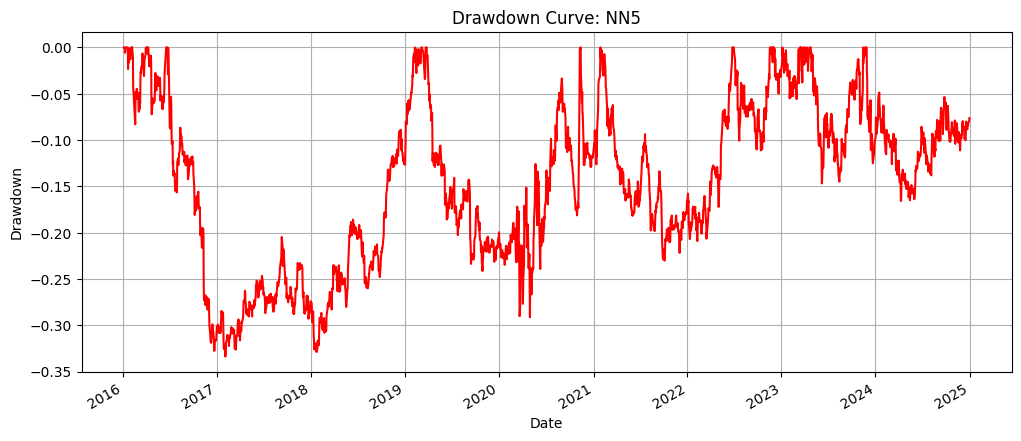

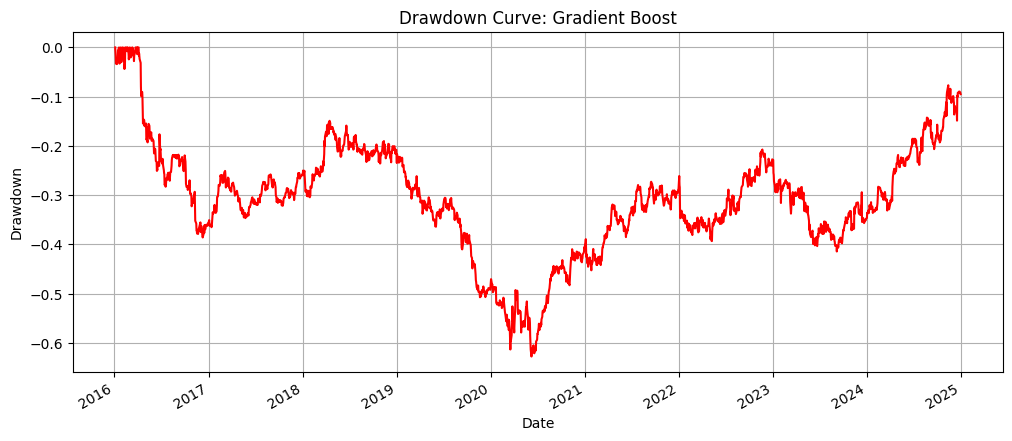

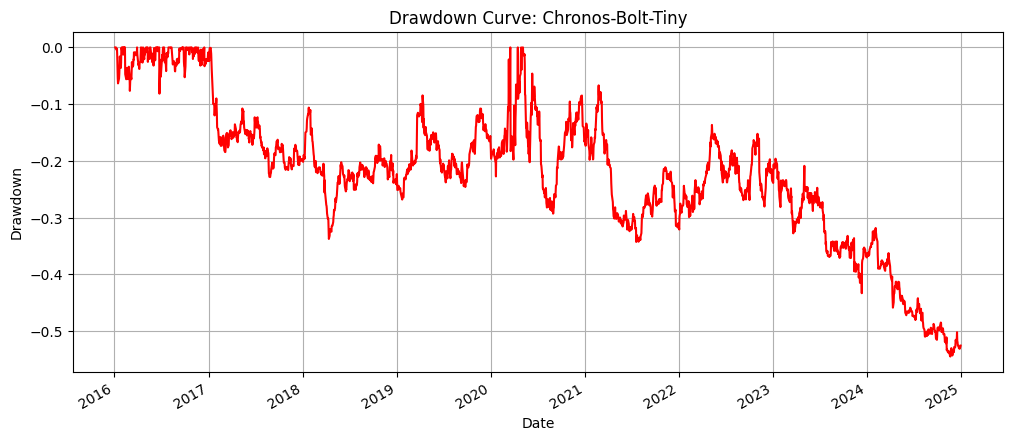

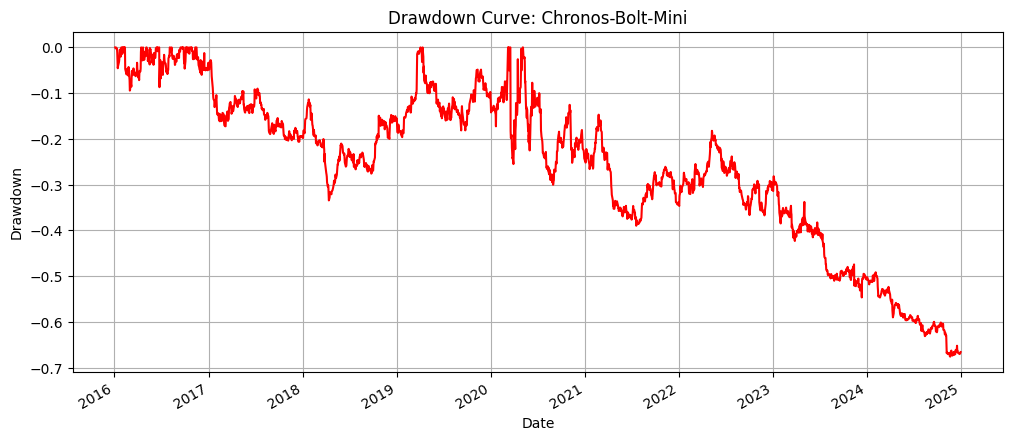

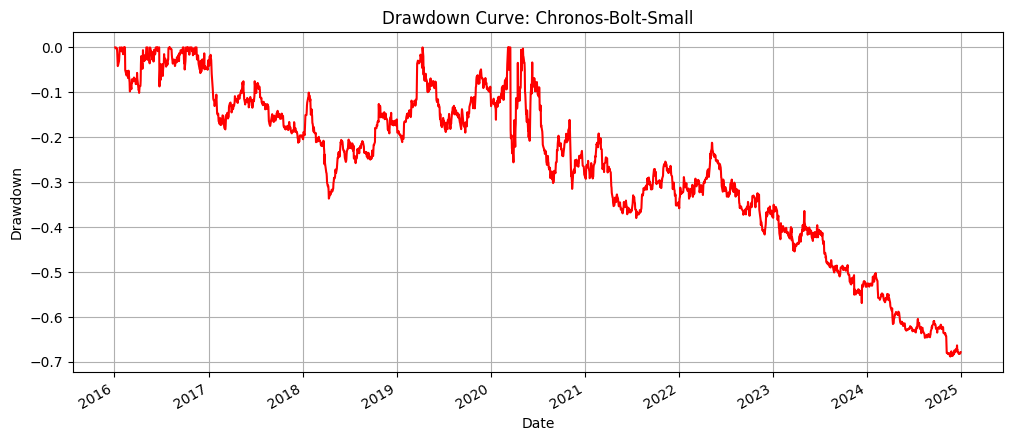

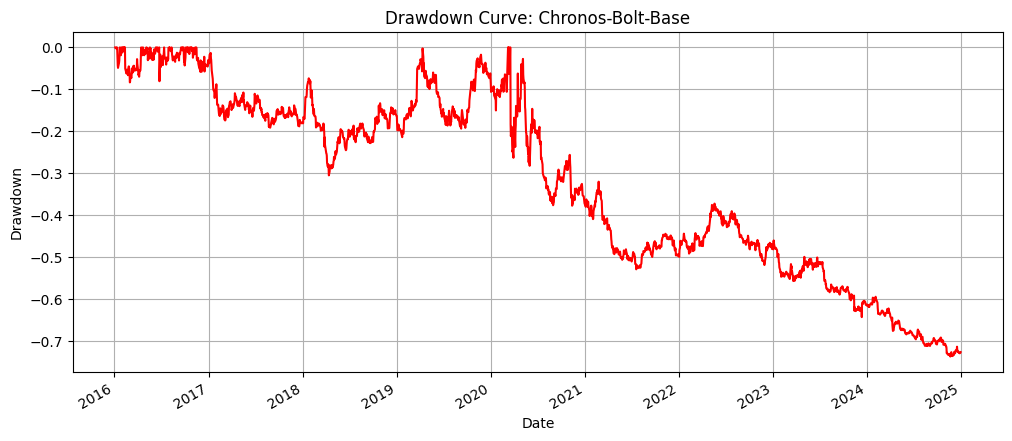

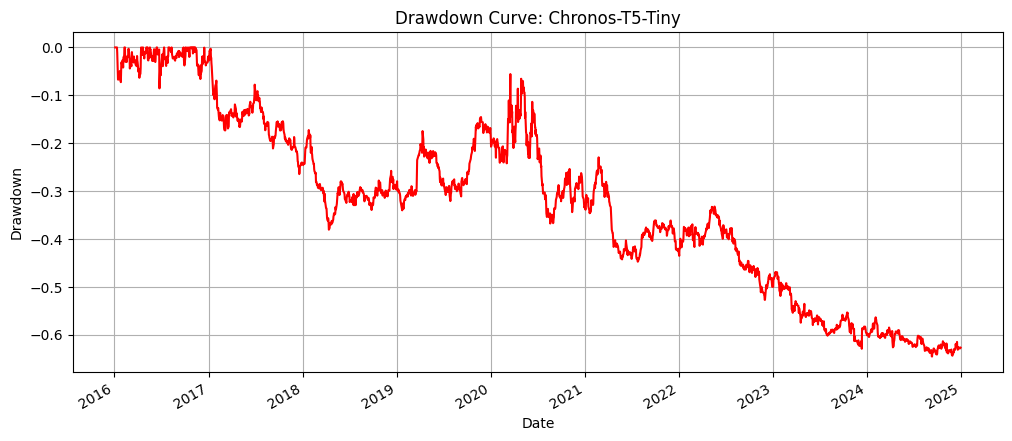

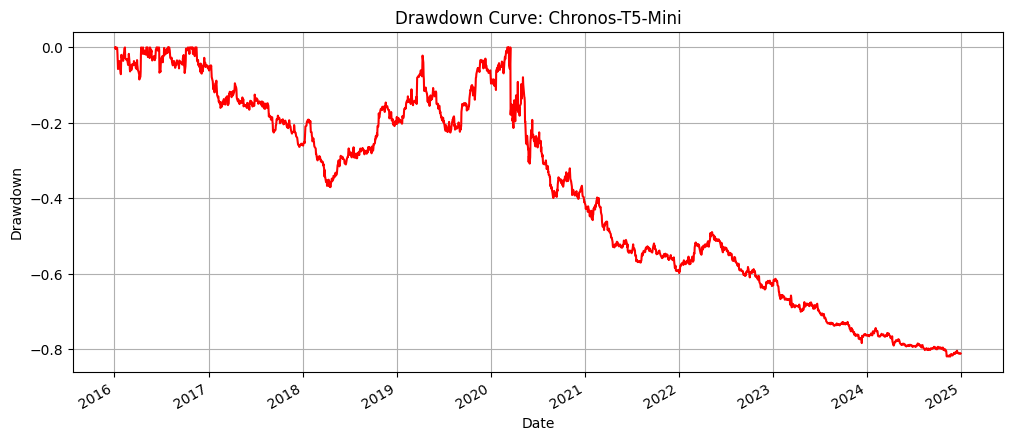

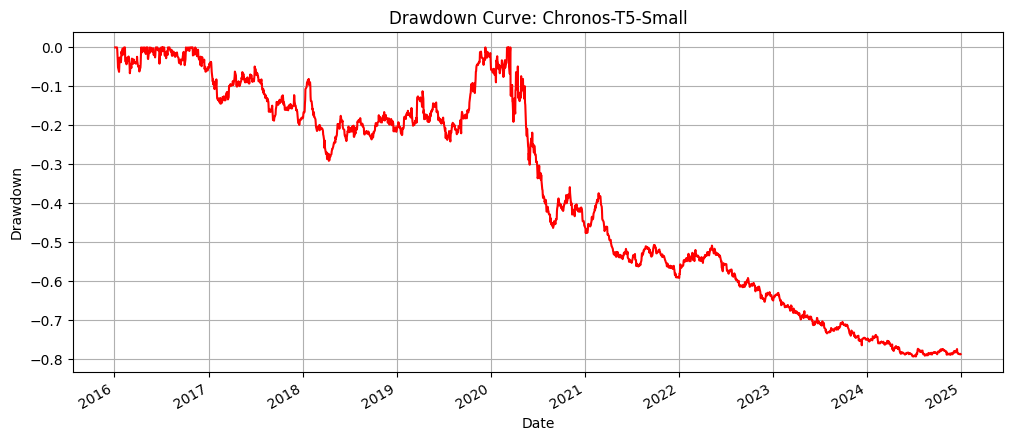

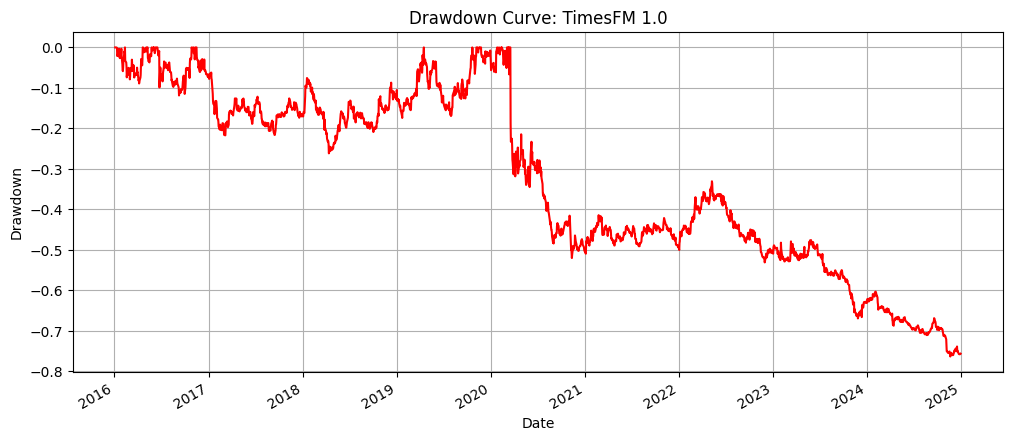

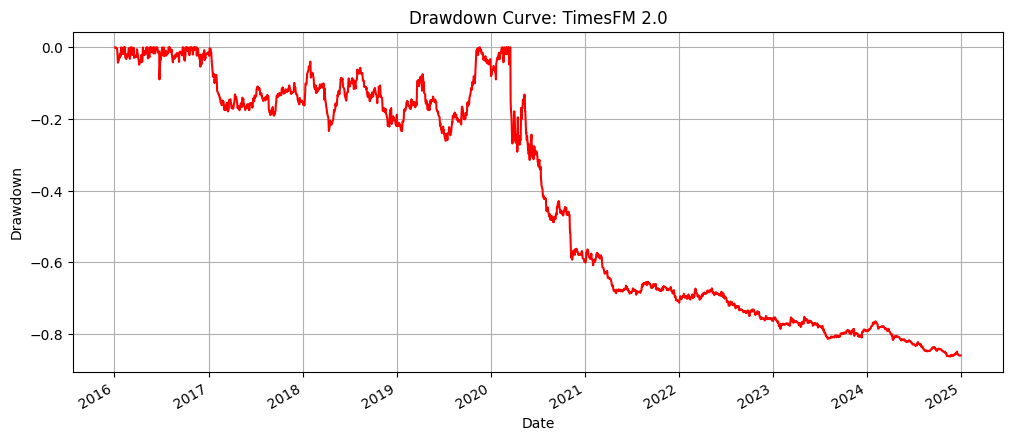

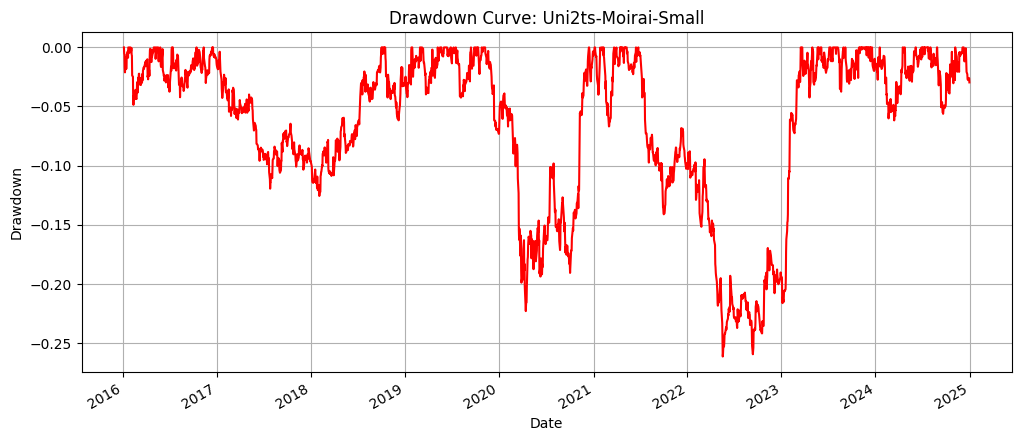

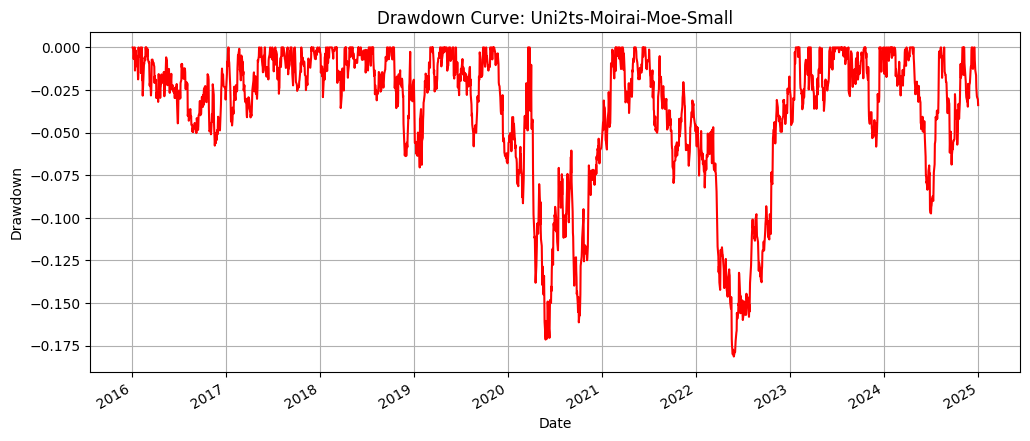

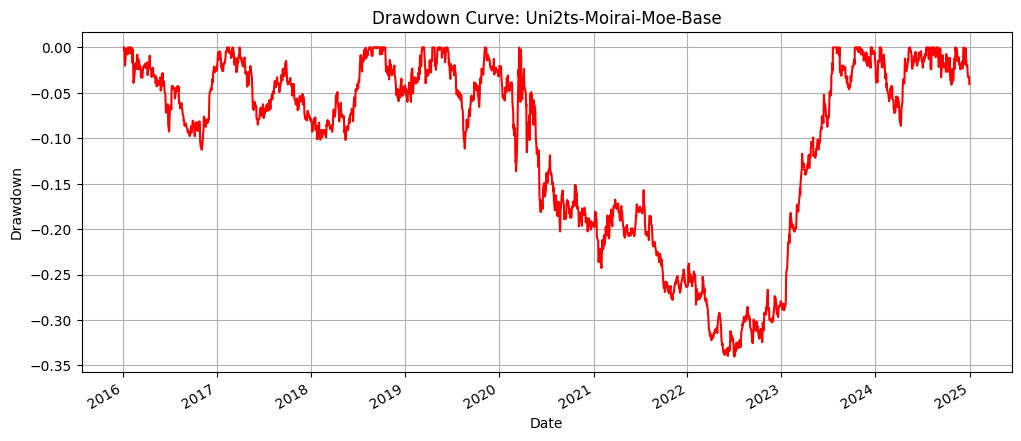

In [170]:
def plot_drawdown(cumulative_returns, models_dict, model_name='Model'):
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / running_max) - 1

    drawdown.plot(figsize=(12, 5), color='red', title=f"Drawdown Curve: {models_dict[model_name]}")
    plt.ylabel("Drawdown")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

for model in model_cols:
    cumulative_returns = (1 + portfolio_df[model]).cumprod()
    plot_drawdown(cumulative_returns, models_dict, model_name=model)